What criteria matters most in making your MVP decision? Answers by some of nba sport writers/analyst
- Steve Aschburner: The MVP is the best player on the team with the best record.
- Fran Blinebury: Consistent individual excellence combined with team leadership and more than a few moments of transcendent brilliance. 
- John Schuhmann: My vote went to the individual who had the biggest effect on why a good team was good. 
- Sekou Smith: I've said all along that there's a complicated matrix of factors that go into making this vote.
- Ian Thomsen: I love this award because it’s all about value: who has done the most for his team? 
- Lang Whitaker: I'm doing my best to keep it simple: Value.

Source: https://www.nba.com/article/2017/04/12/blogtable-what-criteria-matters-most-making-mvp-decision

According to Basketball Reference, "Win Shares is a player statistic which attempts to divvy up credit for team success to the individuals on the team".

In [1]:
# All the packages needed for this project

from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.request import urlopen
from bs4 import BeautifulSoup
import plotly.graph_objects as go

In [2]:
# Import and read 2015-2019 NBA player stats which we scraped eariler 

playerstats_2015 = pd.read_csv('season_2015_stats.csv')
playerstats_2016 = pd.read_csv('season_2016_stats.csv')
playerstats_2017 = pd.read_csv('season_2017_stats.csv')
playerstats_2018 = pd.read_csv('season_2018_stats.csv')
playerstats_2019 = pd.read_csv('season_2019_stats.csv')


In [3]:
# Webscrape 2019-2020 data (Will be used for testing the data)
# 2019-2020 data constantly changes as the season is still in progress

def season_stats(year):
    
    adv_url = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(year)
    adv_html = urlopen(adv_url)
    soup_adv = BeautifulSoup(adv_html)
    
    pg_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)
    pg_html = urlopen(pg_url)
    soup_pg = BeautifulSoup(pg_html)
    
    # To see the column headers we have
    soup_adv.findAll('tr', limit=2)
    # GetText() function will help extract the text from the data we need into a list format
    headers_adv = [th.getText() for th in soup_adv.findAll('tr', limit=2)[0].findAll('th')]
    # Exclude the first column to remove ranking of the players from the webpage
    headers_adv = headers_adv[1:]
    headers_adv
    
    # To see the column headers we have
    soup_pg.findAll('tr', limit=2)
    # GetText() function will help extract the text from the data we need into a list format
    headers_pg = [th.getText() for th in soup_pg.findAll('tr', limit=2)[0].findAll('th')]
    # Exclude the first column to remove ranking of the players from the webpage
    headers_pg = headers_pg[1:]
    headers_pg
    
    # Remove the first header row
    rows_adv = soup_adv.findAll('tr')[1:]
    player_stats_adv = [[td.getText() for td in rows_adv[i].findAll('td')]
                for i in range(len(rows_adv))]

    # Remove the first header row
    rows_pg = soup_pg.findAll('tr')[1:]
    player_stats_pg = [[td.getText() for td in rows_pg[i].findAll('td')]
                for i in range(len(rows_pg))]

    # Year's Player per game stats
    stats_year_pg = pd.DataFrame(player_stats_pg, columns = headers_pg)

    # Use notnull() function to find the non-missing values, when there are missing values in the dataframe.
    stats_year_pg = stats_year_pg[stats_year_pg['Player'].notnull()]

    # stats_2010_pg.drop(stats_2010_pg.index[0])

    # Convert string/object to float
    cols = ['Age', 'G', 'GS','MP', 'FG','3P','FT%','FG%', '3P%','AST', 'STL', 'BLK','TRB', 'PTS','eFG%']
    stats_year_pg[cols] = stats_year_pg[cols].apply(pd.to_numeric, errors='coerce', axis=1)

    # Replacing na values to 0
    stats_year_pg = stats_year_pg[:].fillna(0)

    # Year Player advanced stats
    stats_year_adv = pd.DataFrame(player_stats_adv, columns = headers_adv)

    # Use notnull() function to find the non-missing values, when there are missing values in the dataframe.
    stats_year_adv = stats_year_adv[stats_year_adv['Player'].notnull()]

    # Convert string/object to float
    cols = ['Age', 'G', 'TRB%','AST%','STL%','BLK%','PER','TS%', 'WS','USG%','BPM','VORP']
    stats_year_adv[cols] = stats_year_adv[cols].apply(pd.to_numeric, errors='coerce', axis=1)

    # Replacing na values to 0
    stats_year_adv = stats_year_adv[:].fillna(0)
    
    # Merge both per game and advanced stats
    merged_year_stats = pd.merge(stats_year_pg, stats_year_adv, on=['Player','Tm'], how='outer')

    # Save the datasets

    return merged_year_stats

In [4]:
# Read 2019-2020 dataset
playerstats_2020 = season_stats(2020)
playerstats_2020   

,Player,Pos_x,Age_x,Tm,G_x,GS,MP_x,FG,FGA,FG%,...,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP
0,Steven Adams,C,26.0,OKC,47.0,47.0,26.9,4.4,7.6,0.589,...,,3.0,1.9,4.9,.186,,1.2,3.2,4.4,2.0
1,Bam Adebayo,PF,22.0,MIA,52.0,52.0,34.7,6.3,10.8,0.581,...,,4.0,2.8,6.8,.182,,1.1,3.9,5.0,3.2
2,LaMarcus Aldridge,C,34.0,SAS,48.0,48.0,33.1,7.3,14.5,0.501,...,,3.1,1.3,4.4,.134,,1.3,0.6,1.9,1.5
3,Nickeil Alexander-Walker,SG,21.0,NOP,40.0,0.0,12.5,1.9,5.6,0.342,...,,-0.7,0.3,-0.4,-0.036,,-3.9,-2.1,-6.0,-0.5
4,Grayson Allen,SG,24.0,MEM,30.0,0.0,16.6,2.6,5.9,0.449,...,,0.5,0.2,0.7,.064,,-0.8,-2.6,-3.4,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,Thaddeus Young,PF,31.0,CHI,53.0,9.0,23.8,4.0,8.9,0.444,...,,-0.3,1.6,1.3,.050,,-2.1,0.7,-1.4,0.2
563,Trae Young,PG,21.0,ATL,48.0,48.0,35.2,9.3,20.8,0.444,...,,4.3,0.6,4.9,.140,,7.7,-2.4,5.3,3.1
564,Cody Zeller,C,27.0,CHO,49.0,30.0,23.1,4.3,8.4,0.514,...,,1.9,0.9,2.8,.117,,0.0,-0.3,-0.3,0.5
565,Ante Žižić,C,23.0,CLE,16.0,0.0,9.9,1.8,3.1,0.571,...,,0.4,0.1,0.5,.150,,-2.5,-1.6,-4.0,-0.1


In [5]:
# Stack the DataFrames on top of each other for 2015-2019
vertical_stack = pd.concat([playerstats_2015, playerstats_2016, playerstats_2017, \
                           playerstats_2018, playerstats_2019], axis=0).reset_index()

In [6]:
vertical_stack

,index,Player,Pos_x,Age_x,Tm,G_x,GS,MP_x,FG,FGA,...,,OWS,DWS,WS,WS/48,.1,OBPM,DBPM,BPM,VORP
0,0,Quincy Acy,PF,24.0,NYK,68.0,22.0,18.9,2.2,4.9,...,NaN,1.0,0.7,1.7,0.063,NaN,-2.3,-0.8,-3.1,-0.3
1,1,Jordan Adams,SG,20.0,MEM,30.0,0.0,8.3,1.2,2.9,...,NaN,0.0,0.4,0.4,0.073,NaN,-1.8,1.2,-0.6,0.1
2,2,Steven Adams,C,21.0,OKC,70.0,67.0,25.3,3.1,5.7,...,NaN,1.9,2.2,4.1,0.111,NaN,-1.4,1.8,0.4,1.1
3,3,Jeff Adrien,PF,28.0,MIN,17.0,0.0,12.6,1.1,2.6,...,NaN,0.2,0.2,0.4,0.087,NaN,-2.7,0.5,-2.2,0.0
4,4,Arron Afflalo,SG,29.0,TOT,78.0,72.0,32.1,4.8,11.3,...,NaN,1.6,1.0,2.6,0.050,NaN,-0.5,-1.3,-1.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,703,Tyler Zeller,C,29.0,MEM,4.0,1.0,20.5,4.0,7.0,...,NaN,0.2,0.1,0.3,0.191,NaN,-0.3,-1.3,-1.5,0.0
3192,704,Ante Žižić,C,22.0,CLE,59.0,25.0,18.3,3.1,5.6,...,NaN,1.7,0.3,2.0,0.087,NaN,-1.7,-1.4,-3.1,-0.3
3193,705,Ivica Zubac,C,21.0,TOT,59.0,37.0,17.6,3.6,6.4,...,NaN,1.9,1.3,3.2,0.148,NaN,-1.2,1.0,-0.3,0.5
3194,706,Ivica Zubac,C,21.0,LAL,33.0,12.0,15.6,3.4,5.8,...,NaN,1.1,0.6,1.8,0.165,NaN,-1.3,0.4,-0.9,0.1


In [7]:
# Select specific columns for future analysis

playerstats_training = vertical_stack[['Player', 'Age_x', 'PTS', 'STL', 'BLK','Pos_x','G_x','MP_x','AST','TRB','TRB%','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']]
playerstats_2020 = playerstats_2020[['Player', 'Age_x', 'PTS', 'STL', 'BLK', 'Pos_x','G_x','MP_x','AST','TRB','TRB%','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']]

playerstats_training.columns = ['Player', 'Age_x', 'PTS', 'STL', 'BLK','Pos_x','G_x','MP_x','AST','TRB','TRB%','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']
playerstats_2020.columns = ['Player', 'Age_x', 'PTS', 'STL', 'BLK','Pos_x','G_x','MP_x','AST','TRB','TRB%','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','WS','BPM','VORP']

In [8]:
# 2015-2019 combined dataset
playerstats_training

,Player,Age_x,PTS,STL,BLK,Pos_x,G_x,MP_x,AST,TRB,...,PER,TS%,ORB%,DRB%,STL%,BLK%,USG%,WS,BPM,VORP
0,Quincy Acy,24.0,5.9,0.4,0.3,PF,68.0,18.9,1.0,4.4,...,11.9,0.533,6.9,20.5,1.1,1.4,15.5,1.7,-3.1,-0.3
1,Jordan Adams,20.0,3.1,0.5,0.2,SG,30.0,8.3,0.5,0.9,...,12.8,0.489,4.2,8.7,3.4,2.3,20.4,0.4,-0.6,0.1
2,Steven Adams,21.0,7.7,0.5,1.2,C,70.0,25.3,0.9,7.5,...,14.1,0.549,12.2,19.3,1.1,3.8,14.3,4.1,0.4,1.1
3,Jeff Adrien,28.0,3.5,0.2,0.5,PF,17.0,12.6,0.9,4.5,...,14.2,0.494,11.9,29.6,0.9,3.3,14.3,0.4,-2.2,0.0
4,Arron Afflalo,29.0,13.3,0.5,0.1,SG,78.0,32.1,1.7,3.2,...,10.7,0.533,1.1,9.7,0.8,0.2,19.0,2.6,-1.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,Tyler Zeller,29.0,11.5,0.3,0.8,C,4.0,20.5,0.8,4.5,...,19.4,0.640,12.1,12.5,0.6,3.5,21.8,0.3,-1.5,0.0
3192,Ante Žižić,22.0,7.8,0.2,0.4,C,59.0,18.3,0.9,5.4,...,16.2,0.590,10.6,22.8,0.6,1.8,18.2,2.0,-3.1,-0.3
3193,Ivica Zubac,21.0,8.9,0.2,0.9,C,59.0,17.6,1.1,6.1,...,18.9,0.604,11.9,24.2,0.6,4.0,20.3,3.2,-0.3,0.5
3194,Ivica Zubac,21.0,8.5,0.1,0.8,C,33.0,15.6,0.8,4.9,...,19.5,0.633,11.0,21.2,0.4,4.3,20.5,1.8,-0.9,0.1


# Win Shares Distrubtion among all the players (2015 - 2019)

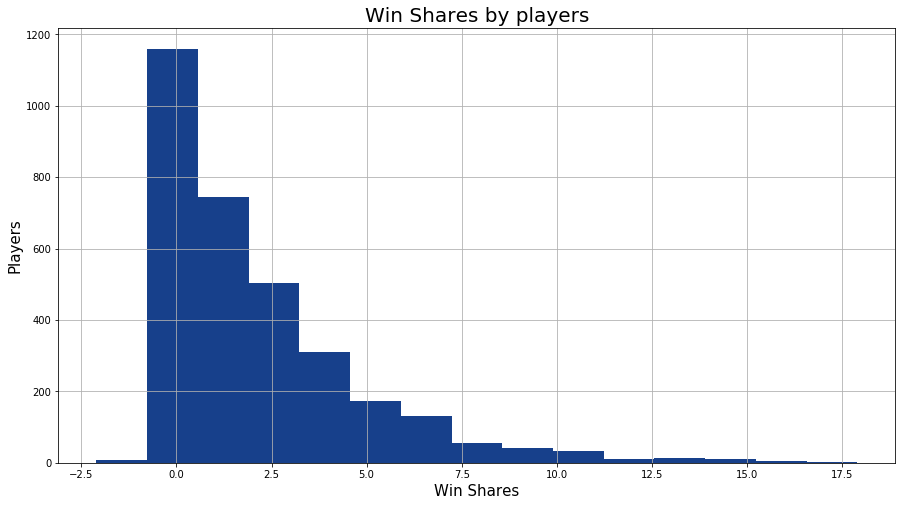

In [9]:
# Plot win shares by players to see how they are distributed
player_winshares_training = playerstats_training[['Player', 'WS']]

plt.figure(figsize = (15,8))
plt.hist(player_winshares_training['WS'], bins = 15, color='#17408B')
plt.grid()
plt.xlabel('Win Shares', size = 15)
plt.ylabel('Players', size = 15)
plt.title('Win Shares by players', size = 20);

There are a high number of players that barely played at all as you can from the previous histo graph. 

# Which features should be used for the model?

### Random Forest

In [10]:
# Fitting random forest regression to the dataset
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.ensemble import RandomForestRegressor

In [11]:
# Select x and y data and convert to numpy array
features = ['Age_x','PTS', 'STL', 'BLK','G_x','MP_x','AST','TRB','TRB%','3P%','FG%','FT%','eFG%','PER','TS%','ORB%','DRB%','STL%','BLK%','USG%','BPM','VORP']
x_data = playerstats_training[features].to_numpy()
y_data = playerstats_training[['WS']].to_numpy()
y_data = y_data.reshape(y_data.shape[0], )

In [12]:
# Create regressor object
regressor = RandomForestRegressor(n_estimators=200)

In [13]:
# Fit the regressor with x and y data
regressor.fit(x_data, y_data)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [14]:
# Sort the values from highest to lowest
sorted_indices = np.argsort(regressor.feature_importances_)[::-1]

In [15]:
# Print the feature ranking from highest to lowest
for index in sorted_indices:
    print(f"{features[index]}: {regressor.feature_importances_[index]}")

VORP: 0.8268331990956972
G_x: 0.06529414628999687
PER: 0.019340688605645282
BPM: 0.01872306282862741
TS%: 0.01529213411489945
TRB: 0.008464358144883381
STL%: 0.006090207127849241
PTS: 0.005846398796175327
MP_x: 0.004278884516780884
FT%: 0.0036084690678199567
FG%: 0.003297753708300023
USG%: 0.0030105800122338473
AST: 0.00293490919917813
eFG%: 0.0026030270538120823
ORB%: 0.002079141514881731
DRB%: 0.002044107523109658
3P%: 0.00203137180284606
BLK%: 0.0019397880327143527
TRB%: 0.0018989179136314393
Age_x: 0.0018007100930056926
STL: 0.0013353511271703867
BLK: 0.0012527934307415972


### Pearson's R-Square Correlation

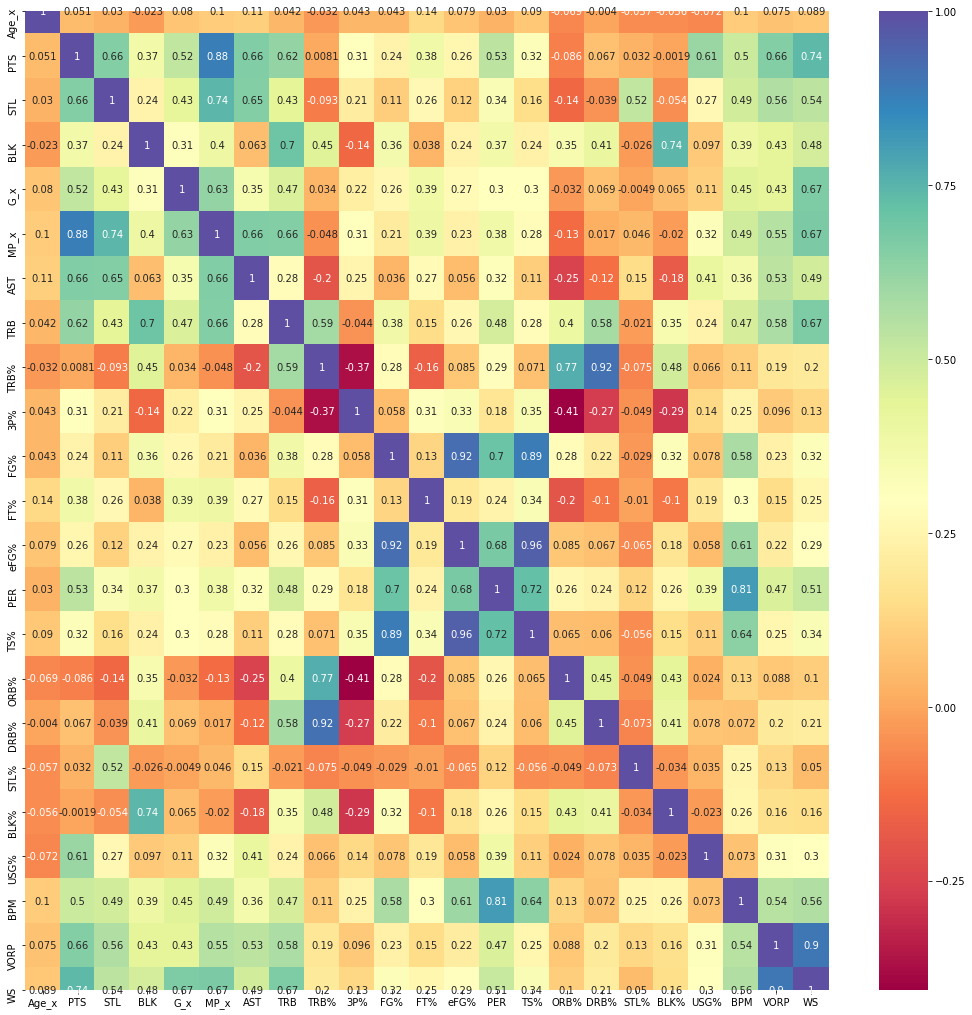

In [16]:
# Plot heatmap to see which features have strong corrletation to win shares with others
playerstats_training = playerstats_training[features + ["WS"]]

fig = plt.figure(figsize=(18, 18))

fig.set_facecolor('white')

sns.heatmap(playerstats_training.corr(), annot=True, cmap="Spectral")

VORP seems to have a very high correlation to win shares. In order to calculate Value Over Replacement Player (VORP), you need to use BPM. Therefore, we will dismiss BPM and use only VORP as one of the important features to do further model analysis. 

Text(0, 0.5, 'Win Shares')

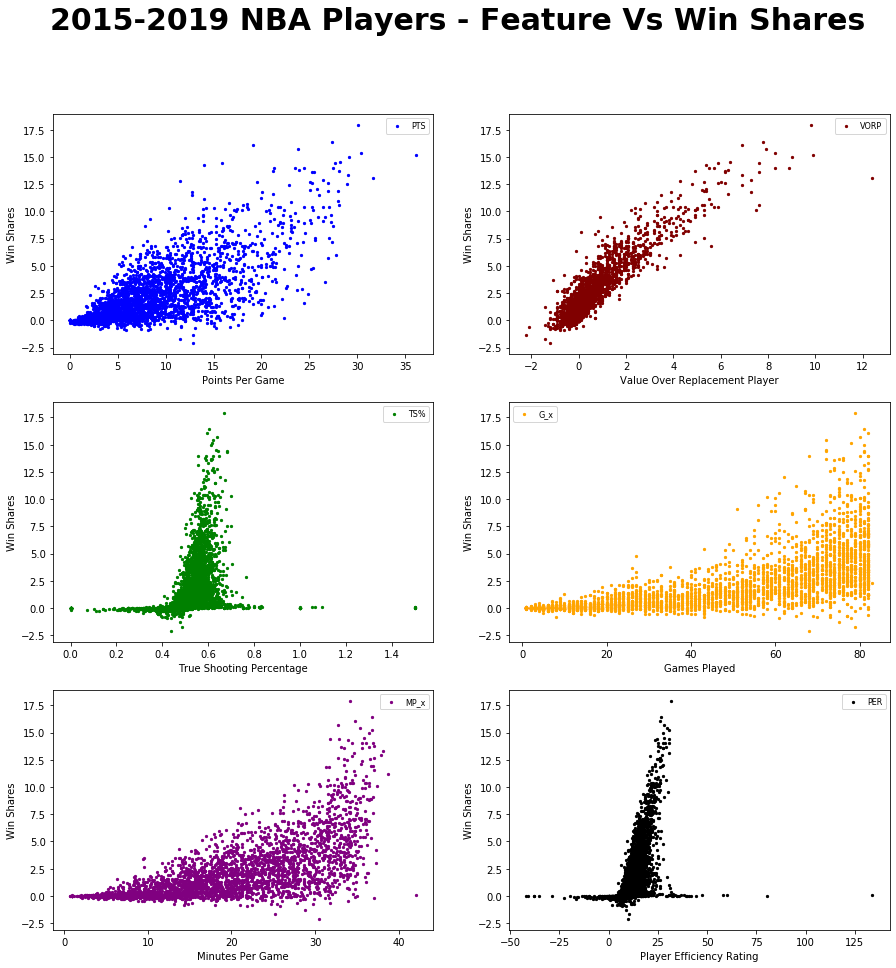

In [17]:
# See how correlated win shares are against selected features. 
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
fig.suptitle('2015-2019 NBA Players - Feature Vs Win Shares', weight = 'bold', size = 30)

ax1.scatter(playerstats_training['PTS'], playerstats_training['WS'], label = "PTS", s = 5, color='blue')
ax1.legend(loc='best', prop={'size': 8, "family": "sans-serif"})
ax1.set_xlabel('Points Per Game')
ax1.set_ylabel('Win Shares')

ax2.scatter(playerstats_training['VORP'], playerstats_training['WS'], label = "VORP", s = 5, color='maroon')
ax2.legend(loc='best', prop={'size': 8, "family": "sans-serif"})
ax2.set_xlabel('Value Over Replacement Player')
ax2.set_ylabel('Win Shares')

ax3.scatter(playerstats_training['TS%'], playerstats_training['WS'], label = "TS%", s = 5, color='green')
ax3.legend(loc='best', prop={'size': 8, "family": "sans-serif"})
ax3.set_xlabel('True Shooting Percentage')
ax3.set_ylabel('Win Shares')

ax4.scatter(playerstats_training['G_x'], playerstats_training['WS'], label = "G_x", s = 5, color='orange')
ax4.legend(loc='best', prop={'size': 8, "family": "sans-serif"})
ax4.set_xlabel('Games Played')
ax4.set_ylabel('Win Shares')

ax5.scatter(playerstats_training['MP_x'], playerstats_training['WS'], label = "MP_x", s = 5, color='purple')
ax5.legend(loc='best', prop={'size': 8, "family": "sans-serif"})
ax5.set_xlabel('Minutes Per Game')
ax5.set_ylabel('Win Shares')

ax6.scatter(playerstats_training['PER'], playerstats_training['WS'], label = "PER", s = 5, color='black')
ax6.legend(loc='best', prop={'size': 8, "family": "sans-serif"})
ax6.set_xlabel('Player Efficiency Rating')
ax6.set_ylabel('Win Shares')

# Model Testing

Perform supervised regression machine learning analysis using the following model to predict win shares for the current NBA season (2019-2020):

 - Linear Regression

In [18]:
# Assign the data to X and y
X = playerstats_training[['PER','VORP','TS%', 'G_x', 'PTS', 'MP_x']]
y = playerstats_training["WS"].values.reshape(-1, 1)
print(X.shape, y.shape)

(3196, 6) (3196, 1)


In [19]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
# Create the model using LinearRegression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [21]:
# Fit (train) or model using the training data
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

print('Model Score: %.2f' % model.score(X_train, y_train))
print('MSE: %.2f' % mean_squared_error(y_test, predictions))
print('MAE: %.2f' % mean_absolute_error(y_test, predictions))

Model Score: 0.91
MSE: 0.56
MAE: 0.50


In [22]:
# Predict Win Shares using Linear Regression Model

# Create a variable for the current season with same selected features used to train the data
current_ws = playerstats_2020[['PER','VORP','TS%', 'G_x', 'PTS', 'MP_x']]

# Predict the win shares of the current dataset 
predict_2020 = model.predict(current_ws)

# Select the first column of data frame (player names)
player_names = playerstats_2020.iloc[:, 0]

# Get the list of tuples from two lists (predicted win shares and current player names) and merge them by using zip().
combined = []
for x,y  in zip(predict_2020, player_names):
    combined.append({'Prediction':x,'Player':y})

# Print combined 
combined

[{'Prediction': array([4.68504364]), 'Player': 'Steven Adams'},
 {'Prediction': array([6.84458469]), 'Player': 'Bam Adebayo'},
 {'Prediction': array([4.37480398]), 'Player': 'LaMarcus Aldridge'},
 {'Prediction': array([0.2561428]), 'Player': 'Nickeil Alexander-Walker'},
 {'Prediction': array([0.59398951]), 'Player': 'Grayson Allen'},
 {'Prediction': array([4.52889812]), 'Player': 'Jarrett Allen'},
 {'Prediction': array([0.10252521]), 'Player': 'Kadeem Allen'},
 {'Prediction': array([0.09824912]), 'Player': 'Al-Farouq Aminu'},
 {'Prediction': array([-0.78632655]), 'Player': 'Justin Anderson'},
 {'Prediction': array([2.0523416]), 'Player': 'Kyle Anderson'},
 {'Prediction': array([-0.23375117]), 'Player': 'Ryan Anderson'},
 {'Prediction': array([10.83391313]), 'Player': 'Giannis Antetokounmpo'},
 {'Prediction': array([-0.36784558]), 'Player': 'Kostas Antetokounmpo'},
 {'Prediction': array([0.25735336]), 'Player': 'Thanasis Antetokounmpo'},
 {'Prediction': array([0.76082709]), 'Player': 'C

In [23]:
# Create a new dataframe with the predictions
new_df = pd.DataFrame(combined)

# Convert predicted values to float and round it to 2 integers
new_df['Prediction'] = round(new_df['Prediction'].astype(float),2)

# Sort the new predicted values from top to bottom and filter only 10 top players
new_df = new_df.sort_values([('Prediction')], ascending = False).head(10)

# Merge the actual win shares from the current dataset we webscraped eariler to the predicted on the dataframe based on the player
current_player_winshares_2020 = playerstats_2020[['Player', 'WS']]
new_df = new_df.merge(current_player_winshares_2020, on = 'Player', how = 'inner')

# Create a new column
# Get the difference between the predicted and actual values 
new_df['Difference'] = new_df['Prediction'] - new_df['WS'] 

# Drop the current index of the DataFrame and replace it with an index of increasing integers
new_df.reset_index(drop=True)
new_df

,Prediction,Player,WS,Difference
0,10.91,James Harden,9.7,1.21
1,10.83,Giannis Antetokounmpo,9.0,1.83
2,9.80,Luka Dončić,6.9,2.90
3,9.48,Damian Lillard,9.3,0.18
4,9.25,LeBron James,7.4,1.85
5,9.14,Nikola Jokić,7.8,1.34
6,7.79,Anthony Davis,8.4,-0.61
7,7.39,Trae Young,4.9,2.49
8,7.03,Ben Simmons,7.0,0.03
9,6.94,Kawhi Leonard,5.7,1.24


In [24]:
# Used Plotly to visualize the data 
# Add data
players_px = new_df["Player"]
prediction_px = new_df["Prediction"]
win_shares_px = new_df["WS"]
difference_px = new_df["Difference"]
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=players_px, y=prediction_px, name='Predicted Win Shares',
                         line=dict(color='#C9082A', width=4)))
fig.add_trace(go.Scatter(x=players_px, y=win_shares_px, name = 'Actual Win Shares',
                         line=dict(color='#17408B', width=4)))
fig.add_trace(go.Scatter(x=players_px, y=difference_px, name='Difference',
                         line=dict(color='black', width=4,
                              dash='dash') # dash options include 'dash', 'dot', and 'dashdot'
))
# Edit the layout
fig.update_layout( xaxis_title='Players',
                   yaxis_title='Win Shares Values',
                   title={
                    'text': "Win Shares",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                   font=dict(
                       size=18,
                       color='black'))
fig.show()

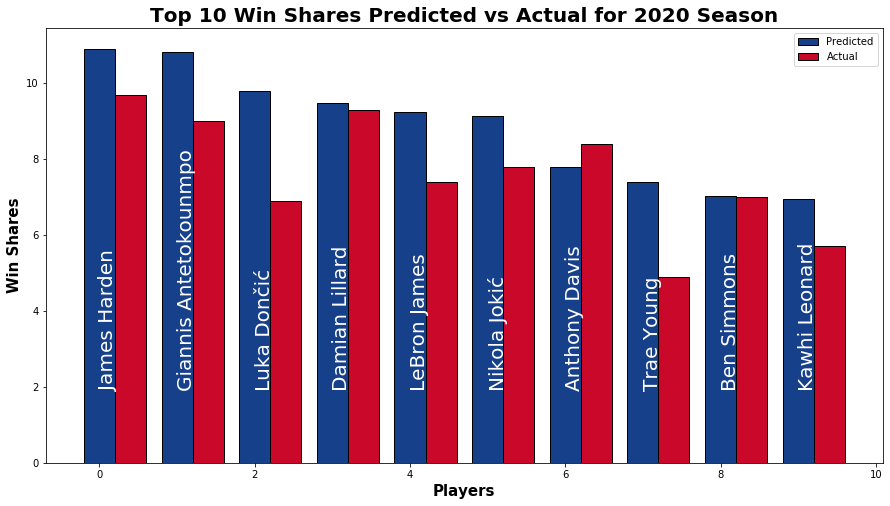

In [25]:
# Finally plot predicted vs actual

# Give variables
rank = np.arange(len(new_df['Prediction']))
ws_predicted = new_df['Prediction'] #Predicted win share Values
ws_actual = new_df['WS'] #Actual win share Values

# The width of the bars
width = 0.4

fig, ax = plt.subplots(figsize = (15,8))

# Need to plot both predicted and actual on the same bar chart
# NBA Logo colors are Dark Cornflower Blue (#17408B)and Philippine Red (#C9082A).
plt.bar(rank, ws_predicted, width, edgecolor = 'black', label = 'Predicted', color='#17408B')
plt.bar(rank + width, ws_actual, width, edgecolor = 'black', label = 'Actual',color = '#C9082A')

# For Loop to get the player names on the graph
for i in rank:
    plt.text(rank[i], 2, s = new_df['Player'][i], rotation = 'vertical',color = 'white', size = 20)                                        

# Add title, axis names and legend
plt.title('Top 10 Win Shares Predicted vs Actual for 2020 Season', weight='bold', size=20)
plt.xlabel('Players', weight='bold', size=15)
plt.ylabel('Win Shares', weight='bold', size=15)
plt.legend(loc='best')


In [26]:
# All Star Selection starters

# List of actual players selected to all-star game
Actual_players = ['LeBron James', 'Anthony Davis', 'Kawhi Leonard', 'Luka Doncic', 'James Harden', 'Giannis Antetokounmpo', 'Joel Embiid','Pascal Siakam', 'Kemba Walker', 'Trae Young'] 
  
# List of predicted players who should have been selected to all-star game based on the prediction
Predicted_players = ['LeBron James', 'Anthony Davis', 'Kawhi Leonard', 'Luka Doncic', 'James Harden', 'Giannis Antetokounmpo', 'Ben Simmons','Nikola Jokic', 'Damian Lillard', 'Trae Young'] 
  
# Calling DataFrame constructor after zipping both lists, with columns specified 
all_star_starters = pd.DataFrame(list(zip(Predicted_players, Actual_players)), 
               columns =['Predicted Starters', 'Actual Starters']) 

# Reset index to start at 1
all_star_starters.index += 1 

all_star_starters.style.apply(lambda x: ['background: yellow' if x.name in [7,8,9] 
                              else '' for i in x], 
                   axis=1)


,Predicted Starters,Actual Starters
1,LeBron James,LeBron James
2,Anthony Davis,Anthony Davis
3,Kawhi Leonard,Kawhi Leonard
4,Luka Doncic,Luka Doncic
5,James Harden,James Harden
6,Giannis Antetokounmpo,Giannis Antetokounmpo
7,Ben Simmons,Joel Embiid
8,Nikola Jokic,Pascal Siakam
9,Damian Lillard,Kemba Walker
10,Trae Young,Trae Young


Predicted 7 out of the 10 starters. But if you consider the reserves then we have predicted all the all-star players.